Importing the dataset

In [174]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [145]:
dataset = tf.keras.utils.image_dataset_from_directory(
     "/content/drive/MyDrive/Plant_Village",
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 3149 files belonging to 3 classes.


In [146]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [147]:
len(dataset)

99

In [148]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1]


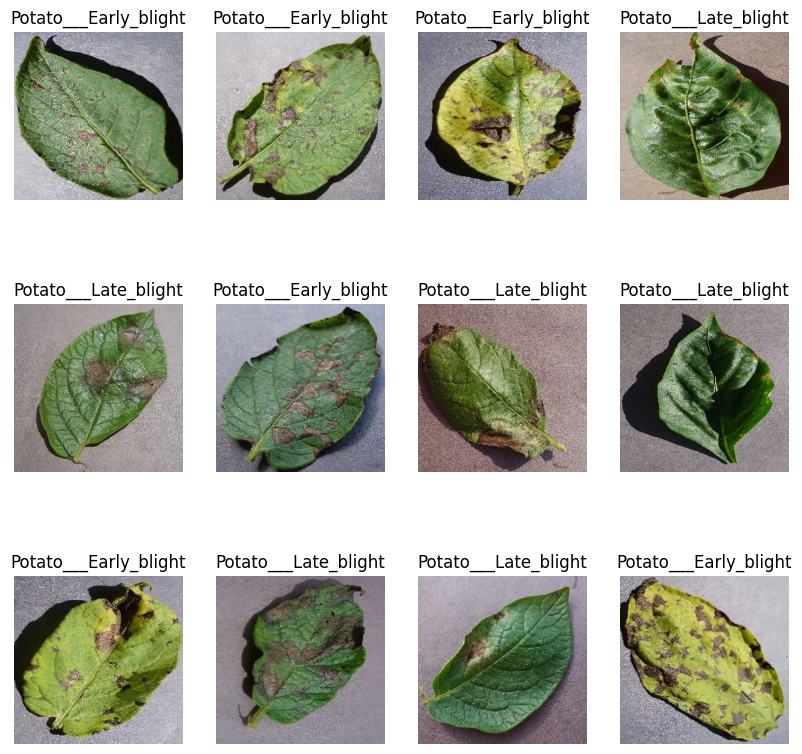

In [149]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Train-Test-Validation split

In [150]:
train_size = 0.8
train_dataset = dataset.take(54)

In [151]:
test_dataset = dataset.skip(54)
len(test_dataset)

45

In [152]:
validation_size = 0.1
validation_dataset = test_dataset.take(6)
len(validation_dataset)

6

In [153]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

39

Data Augmentation

In [154]:
def get_dataset_partitions_tf(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    return train_ds, test_ds, val_ds

In [155]:
 train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [156]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

79
11
9


In [157]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [158]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0/255)
])

In [159]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

Building and training a CNN model

In [160]:
input_shape = (32, 256, 256, 3)


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = "relu", input_shape = (256, 256)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(3, activation = "softmax"),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [161]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 516128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 64)               │    33,032,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,033,347 (126.01 MB)

 Trainable params: 33,033,347 (126.01 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

Model evaluation

In [163]:
history = model.fit(
    train_ds,
    epochs = 25,
    batch_size = 32,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.6042 - loss: 7.0220 - val_accuracy: 0.7951 - val_loss: 0.5763
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8297 - loss: 0.4086 - val_accuracy: 0.8854 - val_loss: 0.3742
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8588 - loss: 0.3404 - val_accuracy: 0.9340 - val_loss: 0.2032
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9033 - loss: 0.2511 - val_accuracy: 0.8681 - val_loss: 0.3492
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9187 - loss: 0.2050 - val_accuracy: 0.8611 - val_loss: 0.2911
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9115 - loss: 0.2266 - val_accuracy: 0.8715 - val_loss: 0.3218
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9246 - loss: 0.2038 - val_accuracy: 0.7569 - val_loss: 0.6078
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9376 - loss: 0.1693 - val_accuracy: 0.7014 -

In [164]:
history

In [165]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 79}

In [166]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [167]:
len(history.history['accuracy'])

25

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = len(history.history['accuracy'])

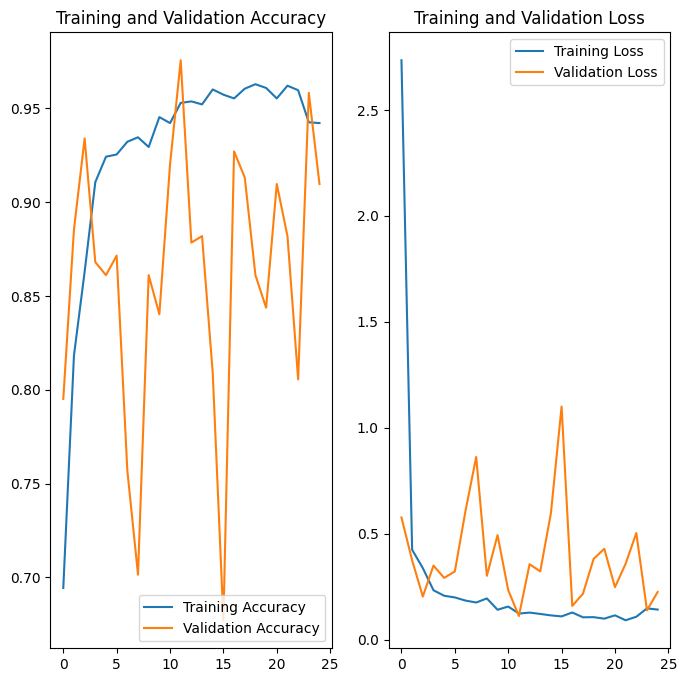

In [169]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

Making inferences

first image to predict
first image's actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
predicted label Potato___Early_blight


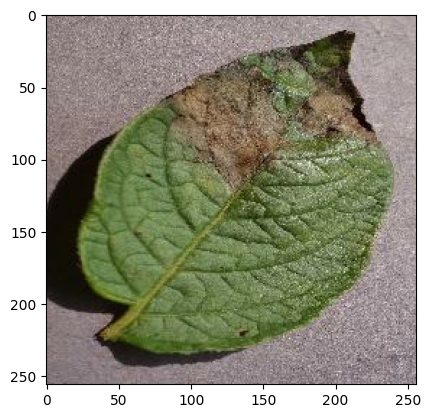

In [170]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label", class_names[np.argmax(batch_prediction[0])])

In [171]:
def predict(model, img) :
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


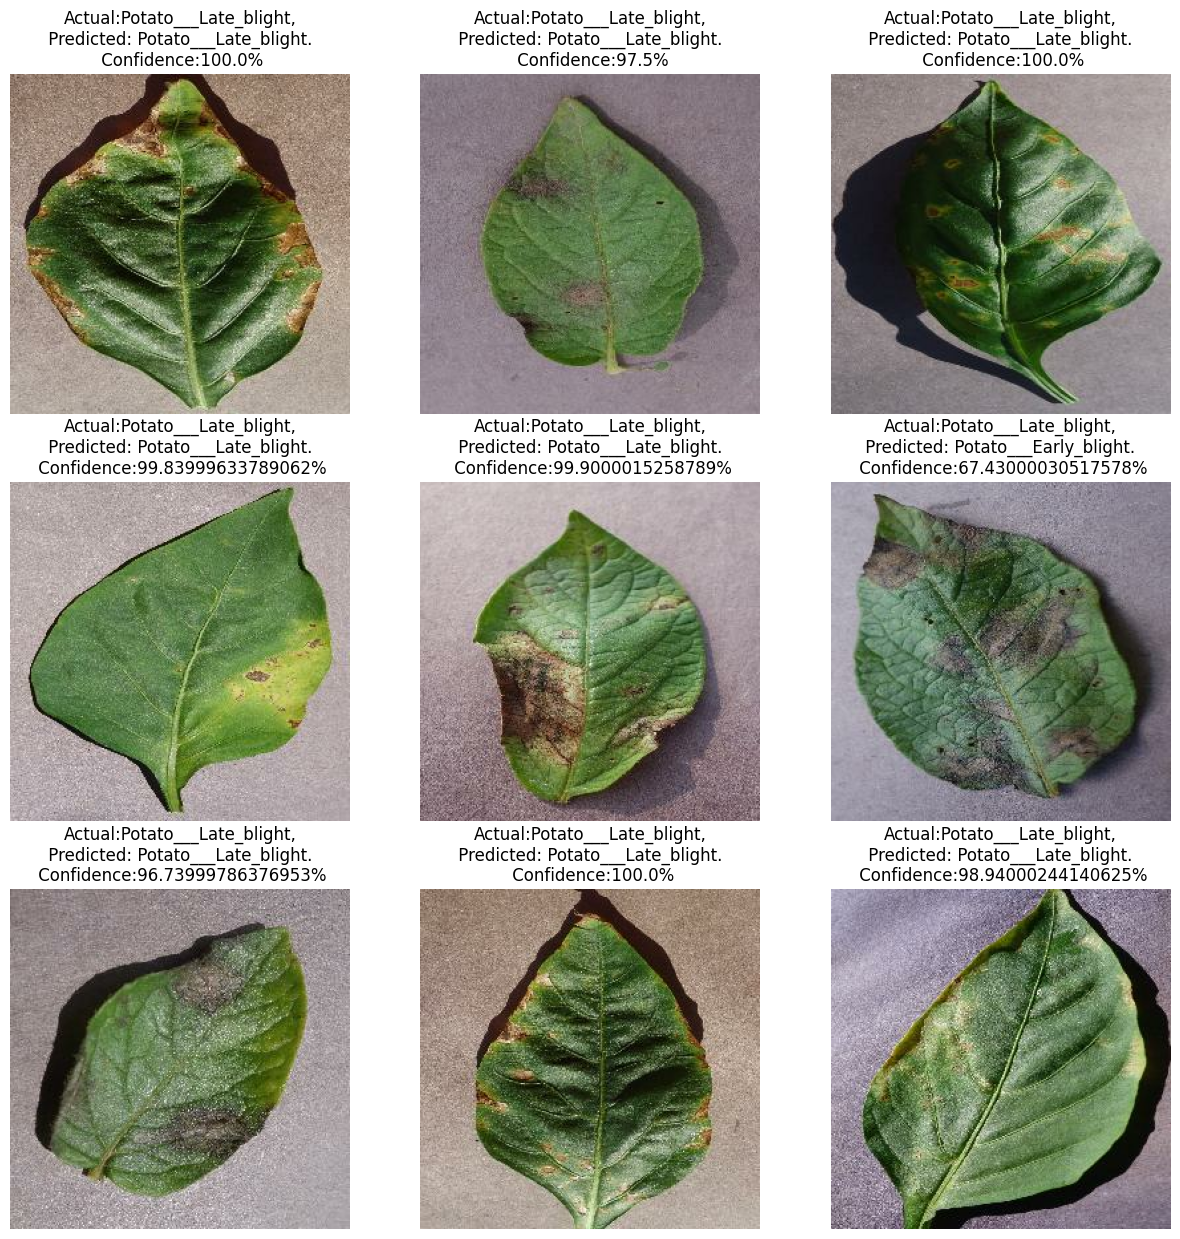

In [172]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}. \n Confidence:{confidence}%")

    plt.axis("off")

Exporting the model

In [173]:
import os

model_version = 1
os.makedirs('/content/drive/MyDrive/models/', exist_ok=True)
model.save("/content/drive/MyDrive/models/plant_disease_model.keras")